# LABORATORIO 4. UTILIZANDO DATOS DE COPERNICUS PARA ANALIZAR LA PRESENCIA DE CIANOBACTERIAS EN LOS LAGOS ATITLÁN Y AMATITLÁN PARTE 2


*   **Irving Acosta 22781**
*   **Ricardo Chuy 221007**

> NOTA, como Lynette ha indicado que si se formatea bien el jupyter puede entregarse sin PDF, este Jupyter resume el trabajo realizado en la segunda parte del laboratorio, donde nos enfocamos en el desarrollo de modelos predictivos sobre los lagos de Atitlan y Amatitlán respecto a la presencia de la cianobacteria/clorofila-a. El repositorio de trabajo es el mismo que la fase anterior y en este jupyter se detallo lo realizado para la segunda parte únicamente por fines de practicidad.

*   [Repositorio](https://github.com/wwIrvingww/Lab4_DS.git)



In [ ]:
!pip install openeo
!pip install rasterio

In [ ]:
# Conectar Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Configurar carpeta de trabajo en Drive
import os
work_dir = "/content/drive/MyDrive/CC3084_Lab4_Atitlan"
os.makedirs(work_dir, exist_ok=True)
os.chdir(work_dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import openeo
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Análisis lago de Atitlan

El óbjetivo de esta parte de la investigación es poder analizar el comportamiento de las cianobacterias en el lago de Atitlan a lo largo del tiempo. Para esto se estará trabajando con datos geoespaciales obtenidos del satélite Sentinel 2. Ahora bien, es importante tener en cuenta que las imágenes del satélite se toman cada 5 días aproximadamente y que se desea trabajar con información de al menos 3 meses atrás. Pero el detalles está en que no todas las imagenes tomadas en ese lapso de tiempo son 100% visibles. Las imagenes pueden estar afectadas por la nubosidad, oscuridad o incluso las imágenes pueden tener errores y/o obstruidas. Es por eso que se realizó una selección de fechas y las imagenes se obtuvieron de la API individualmente.

## Conexión con la API sentinel 2

In [ ]:
#1-3

connection = openeo.connect("https://openeo.dataspace.copernicus.eu").authenticate_oidc()

# Coordenadas exactas del Lago Atitlán
lago_atitlan = {
    "west": -91.326256,
    "east": -91.07151,
    "south": 14.5948,
    "north": 14.750979
}

fechas_prueba = [
    # Febrero (2 fechas)
    "2025-02-07",
    "2025-02-27",

    # Marzo (2 fechas)
    "2025-03-04",
    "2025-03-26",

    # Abril (2 fechas)
    "2025-04-03",
    "2025-04-28",

    # Mayo (2 fechas)
    "2025-05-03",
    "2025-05-28",

    # Julio (2 fechas - no hay datos en junio)
    #"2025-07-10", esta de aca tiene falla y parte de la imagen parece estar cortado
    "2025-07-24",

    # Agosto (1 fecha disponible)
    "2025-08-01"
]


Authenticated using refresh token.


Se deben de incluir distintas bandas necesarias para poder luego visualizr la imagen, hacer cálculos y la visualización de las cianobacterias. La inclusión de más bandas vuelve más pesado el procesamiento y descarga de la imagen, pero nos apoyamos en colab y drive para obtener y guardar las imagenes.

In [ ]:
def descargar_bandas(fecha, overwrite=False):
    """Descarga solo las bandas necesarias para el análisis"""
    nombre_archivo = f"Atitlan_bands_{fecha.replace('-','')}.tif"
    ruta_completa = os.path.join(work_dir, nombre_archivo)

    if os.path.exists(ruta_completa) and not overwrite:
        print(f"Archivo {nombre_archivo} ya existe. Saltando...")
        return True

    try:
        print(f"\nDescargando bandas para: {fecha}")

        # Bandas mínimas necesarias para el script de cianobacterias
        atitlan_cube = connection.load_collection(
            "SENTINEL2_L2A",
            spatial_extent=lago_atitlan,
            temporal_extent=[fecha, fecha],
            bands=["B02", "B03", "B04", "B05", "B08", "B11", "B12"]
        )

        # Guardar resultado
        result = atitlan_cube.save_result(format="GTIFF")
        job = connection.create_job(result)
        job.start_and_wait()
        job.download_results(nombre_archivo)

        print(f"Descarga completada: {nombre_archivo}")
        return True

    except Exception as e:
        print(f"Error descargando {fecha}: {str(e)}")
        return False


In [ ]:
# Descargar bandas para todas las fechas
for fecha in fechas_prueba:
    descargar_bandas(fecha)

Archivo Atitlan_bands_20250207.tif ya existe. Saltando...
Archivo Atitlan_bands_20250227.tif ya existe. Saltando...
Archivo Atitlan_bands_20250304.tif ya existe. Saltando...
Archivo Atitlan_bands_20250326.tif ya existe. Saltando...
Archivo Atitlan_bands_20250403.tif ya existe. Saltando...
Archivo Atitlan_bands_20250428.tif ya existe. Saltando...
Archivo Atitlan_bands_20250503.tif ya existe. Saltando...
Archivo Atitlan_bands_20250528.tif ya existe. Saltando...
Archivo Atitlan_bands_20250724.tif ya existe. Saltando...
Archivo Atitlan_bands_20250801.tif ya existe. Saltando...


Una vez obtenidas las imagenes y descargadas en el entorno, se puede aplicar el script de Cyanobacterias para poder analizar las bacterias en el lago de atitlan mediante imágenes satelitales. Nota importante, el scrip es una adaptación del código dentro de:
https://custom-scripts.sentinel-hub.com/sentinel-2/cyanobacteria_chla_ndci_l1c/. Hay distintas formas de aplicar un script de sentinel hub, pero realizar esta adaptación de python fue la opción que dió los mejores resultados.


In [ ]:
#3 adaptación del script de cianobacterias
def aplicar_script_cyan_local(fecha):

    input_file = f"Atitlan_bands_{fecha.replace('-','')}.tif"
    output_file = f"Atitlan_cyan_{fecha.replace('-','')}.tif"

    if not os.path.exists(input_file):
        print(f"Archivo de entrada {input_file} no encontrado")
        return False

    try:
        with rasterio.open(input_file) as src:
            # Leer todas las bandas
            bandas = src.read()
            meta = src.meta

            # Asignar bandas según el script
            B02 = bandas[0]  # Blue
            B03 = bandas[1]  # Green
            B04 = bandas[2]  # Red
            B05 = bandas[3]  # Red Edge 1
            B08 = bandas[4]  # NIR
            B11 = bandas[5]  # SWIR1
            B12 = bandas[6]  # SWIR2

            # Inicializar matriz de resultados
            chl_result = np.zeros(B02.shape, dtype=np.float32)

            # Función mejorada para detección de agua
            def water_detection(g, nir, swir1, swir2):
                try:
                    # Cálculo de índices de agua con protección contra división por cero
                    mndwi = (g - swir1) / (g + swir1 + 1e-10)
                    ndwi = (g - nir) / (g + nir + 1e-10)
                    # Umbrales ajustados basados en literatura científica
                    return 1 if (mndwi > 0.12 or ndwi > 0.15) else 0
                except:
                    return 0

            # Función mejorada para cálculo de NDCI
            def calculate_ndci(red, red_edge):
                return (red_edge - red) / (red_edge + red + 1e-10)  # Protección contra división por cero

            # Aplicar el script pixel por pixel
            for i in range(B02.shape[0]):
                for j in range(B02.shape[1]):
                    # Verificar si es agua
                    is_water = water_detection(B03[i,j], B08[i,j], B11[i,j], B12[i,j])

                    if is_water == 1:
                        # Calcular NDCI
                        ndci = calculate_ndci(B04[i,j], B05[i,j])

                        # Solo procesar si NDCI es positivo (posible presencia de algas)
                        if ndci > -0.1:  # Umbral más bajo para captar variaciones
                            # Modelo mejorado para estimación de clorofila-a
                            if ndci <= 0:
                                chl = 0.5 + 2.5 * (ndci + 0.1)  # Modelo lineal para valores bajos
                            else:
                                # Modelo polinomial para valores positivos
                                chl = 14.039 + 86.115 * ndci + 194.325 * (ndci**2)

                            # Aplicar umbral mínimo y máximo
                            chl_result[i,j] = np.clip(chl, 0, 100)  # Valor máximo razonable
                        else:
                            chl_result[i,j] = 0
                    else:
                        chl_result[i,j] = 0  # No es agua

            # Guardar resultado
            meta.update({
                'count': 1,
                'dtype': 'float32',
                'nodata': 0
            })

            with rasterio.open(output_file, 'w', **meta) as dst:
                dst.write(chl_result, 1)

        print(f"Procesamiento completado: {output_file}")
        return True

    except Exception as e:
        print(f"Error procesando {fecha}: {str(e)}")
        return False

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import os

def visualizar_truecolor(fecha, directorio=None):
    """
    Visualiza la imagen en true color (RGB) para una fecha específica

    """
    # Configurar directorio
    if directorio is None:
        directorio = os.getcwd()

    # Construir nombre del archivo
    nombre_archivo = f"Atitlan_bands_{fecha.replace('-','')}.tif"
    ruta_completa = os.path.join(directorio, nombre_archivo)

    # Verificar si el archivo existe
    if not os.path.exists(ruta_completa):
        print(f"Error: No se encontró el archivo {nombre_archivo}")
        print("Asegúrate de que:")
        print(f"1. La fecha {fecha} está en las fechas procesadas")
        print("2. Has descargado las bandas B02, B03, B04")
        return

    # Función de normalización
    def normalize(band):
        band_min, band_max = np.percentile(band[band > 0], (2, 98))
        return np.clip((band - band_min) / (band_max - band_min), 0, 1)

    try:
        with rasterio.open(ruta_completa) as src:
            blue = src.read(1)
            green = src.read(2)
            red = src.read(3)

            # Mejor normalización específica para cuerpos de agua
            def water_normalize(band):
                # Excluir valores nulos y aplicar stretch lineal
                band_data = band[band > 0]
                if len(band_data) == 0:
                    return np.zeros_like(band)

                p2, p98 = np.percentile(band_data, (5, 95))  # Ajuste de percentiles
                return np.clip((band - p2) / (p98 - p2), 0, 1)

            # Aplicar corrección gamma para mejorar contraste
            gamma = 0.8
            r_norm = water_normalize(red) ** gamma
            g_norm = water_normalize(green) ** gamma
            b_norm = water_normalize(blue) ** gamma

            # Mezcla de colores para resaltar el agua
            rgb = np.dstack([r_norm, g_norm, b_norm])

            # Visualización
            plt.figure(figsize=(12, 8))
            plt.imshow(rgb)
            plt.title(f"True Color (RGB) - Lago Atitlán\n{fecha}")
            plt.axis('off')

            # Añadir barra de escala (opcional)
            plt.colorbar(label='Reflectancia Normalizada', orientation='horizontal', pad=0.05)

            plt.tight_layout()
            plt.show()

    except Exception as e:
        print(f"Error al procesar la imagen: {str(e)}")

# Ejemplo de uso:
# visualizar_truecolor("2025-02-07", directorio="/content/drive/MyDrive/CC3084_Lab4_Atitlan")

Una vez cargadas las imagenes, con el fin de revisar la calidad de las imagenes obtenidas, se pueden usar las bandas para mostrarlas en su forma true color. En este caso se usan 3 bandas, donde cada una representa el color rojo, verde y azul. Las imagenes a continuación se encuentran en orden cronológico.

Viendo las imagenes podemos ver que son bastante buenas y de estas la nubosidad no es problema para ninguna. Ahora bien puede que algunas de las imágenes no tengan un procesamiento y análisis de Ciano Bacterias muy eficiente, ya que parecen estar un poco más oscuras. El clima o bien el momento en el que se tomó la imagen desde el satélite puede que influya en los resultados de esta investigación. Habiendo visto que las imágenes son aptas y sin errores mayores, ahora se procede a aplicar las transformaciones para ver el comportamiento de las cianobacterias con el script adaptado a python.

In [ ]:
import warnings

# Aplicar script localmente para todas las fechas
for fecha in fechas_prueba:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        aplicar_script_cyan_local(fecha)

Procesamiento completado: Atitlan_cyan_20250207.tif


Procesamiento completado: Atitlan_cyan_20250227.tif


Procesamiento completado: Atitlan_cyan_20250304.tif


Procesamiento completado: Atitlan_cyan_20250326.tif


Procesamiento completado: Atitlan_cyan_20250403.tif


Procesamiento completado: Atitlan_cyan_20250428.tif


Procesamiento completado: Atitlan_cyan_20250503.tif


Procesamiento completado: Atitlan_cyan_20250528.tif


Procesamiento completado: Atitlan_cyan_20250724.tif
Procesamiento completado: Atitlan_cyan_20250801.tif


In [ ]:
#5 carga de los archivos guardados y guardarlos como un diccionario de arreglos

def cargar_datos_cianobacterias(fechas):
    """Carga todos los datos de cianobacterias en un diccionario de arrays"""
    datos = {}
    for fecha in fechas:
        archivo = f"Atitlan_cyan_{fecha.replace('-','')}.tif"
        with rasterio.open(archivo) as src:
            datos[fecha] = {
                'array': src.read(1),
                'metadata': src.meta
            }
    return datos

# Cargar todos los datos
datos_cian = cargar_datos_cianobacterias(fechas_prueba)

# Analisis temporal

Luego de haber procesado cada una de las imágenes y de guardar la información en distintos arreglos para cade fecha, se puede realizar un análisis del comportamiento de la cianobacteria en el Lago de Atitlan en los últimos meses. Obviamente no tenemos todas las fechas de cada día, más que todo por temas tiempo, pero si tenemos distintos ejemplos de los últimos meses. Para poder analizar primero la cantidad de bacterias, se realiza un índice de cianobacterias y luego se grafica dicho índice en el tiempo.

In [ ]:
#6.1 calcular indice promedio de cianobacteria por lago y fecha

def calcular_promedio_por_fecha(datos_cian):
    promedios = {}
    for fecha, data in datos_cian.items():
        arr = data['array']
        # Excluir valores cero (no agua) y calcular promedio
        valores_cian = arr[arr > 0]
        promedios[fecha] = np.mean(valores_cian) if len(valores_cian) > 0 else 0
    return promedios

promedios_attilan = calcular_promedio_por_fecha(datos_cian)

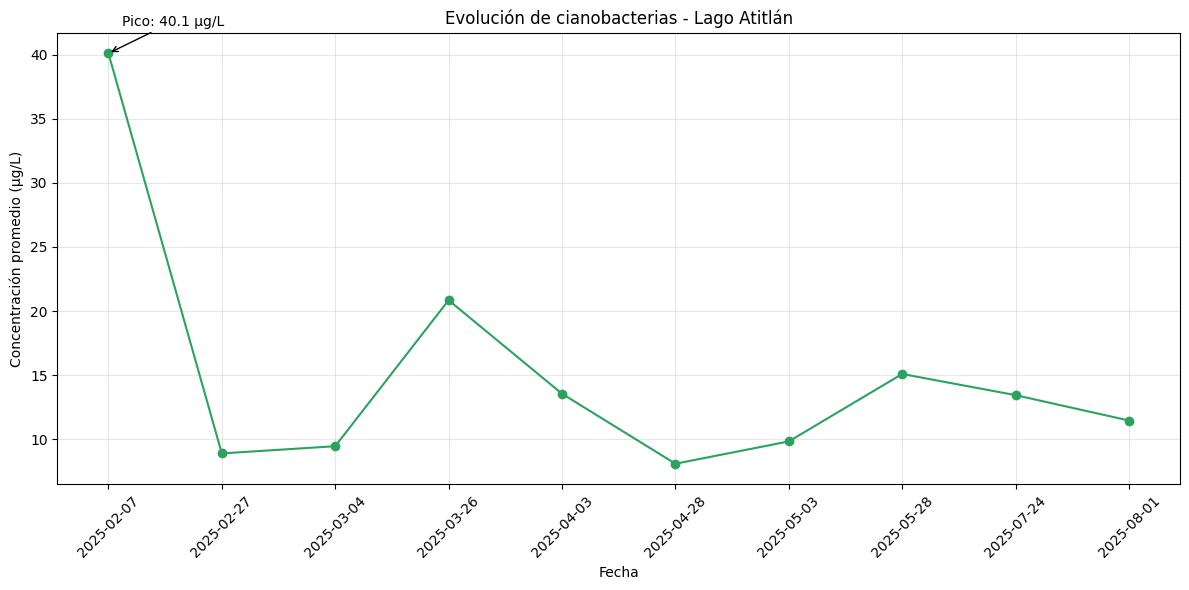

In [ ]:
def graficar_evolucion_temporal(promedios, titulo):
    fechas = sorted(promedios.keys())
    valores = [promedios[f] for f in fechas]

    plt.figure(figsize=(12, 6))
    plt.plot(fechas, valores, marker='o', linestyle='-', color='#2ca25f')

    # Formateo
    plt.title(f"Evolución de cianobacterias - {titulo}")
    plt.ylabel("Concentración promedio (µg/L)")
    plt.xlabel("Fecha")
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

    # Identificar picos
    max_val = max(valores)
    if max_val > 10:  # Umbral para floración significativa
        idx_max = valores.index(max_val)
        plt.annotate(f'Pico: {max_val:.1f} µg/L',
                     xy=(fechas[idx_max], max_val),
                     xytext=(10, 20), textcoords='offset points',
                     arrowprops=dict(arrowstyle='->'))

    plt.tight_layout()
    plt.savefig(f"evolucion_temporal_{titulo.lower()}.png", dpi=150)
    plt.show()

graficar_evolucion_temporal(promedios_attilan, "Lago Atitlán")

Viendo la gráfica y obteniendo los valores más altos dentro de la misma, podemos ver que hay específicamente 3 picos con mayor índice de cianobacteria. Siendo el primero justo en la primera imagen con un índice de 40.11 ug/L en el 7-02-2025. El segundo valor más alto es de 20.87 en en el 26 de abril y el tercero es de 15.09 en el 5 28 de mayo. El comportamiento es algo inusual, ya que de un día de un mes a otro pareciera que la cantidad de bacteria dimsinuye y vuelve a aumentar. Esto podría deberse tal vez a las imagenes que presentaban más oscuridad, puede que no se estén detectando del todo por la calidad de la imagen. Pero aún así se puede ver que si hay contaminación en el lago. Para ver esto con mayor claridad, es posible mostrar la presencia de cianobacterias directamente sobre el mapa de cada uno de los días.

# Serie temporal con lago de Atitlán

Ahora que ya se tiene más información del comportamiento de las cianobacterias y el índice de que muestra la presencia de las mismas, es posible realizar una serie de tiempo para analizar como será el comportamiento de la cianobacteria en el futuro, por ejemplo en el siguiente mes. Como se mencionó anteriormente, se han tenido algunas dificultades para obtener las imagenes satelitales de cda mes, debido a imagenes erroneas o incluso el propio clima. Por lo que para hacer una serie de tiempo será necesario emplear algunas estrategias para para obtener más datos. Específicamente hacemos uso de la interpolación de datos, para que al final tengamos datos intermedios entre los datos calculados. Usamos interpolación quadrática para simular los resultados de las fechas que no tenemos, usando la gráfica de índice de  cianobacteria.

La razón por la que usamos quadrática es por que las relaciones de variables ambientales generalmente no son linealea o tienden a ser complejoas, entonces puede ser mejor usar un ajuste más flexible en vez del lineal.

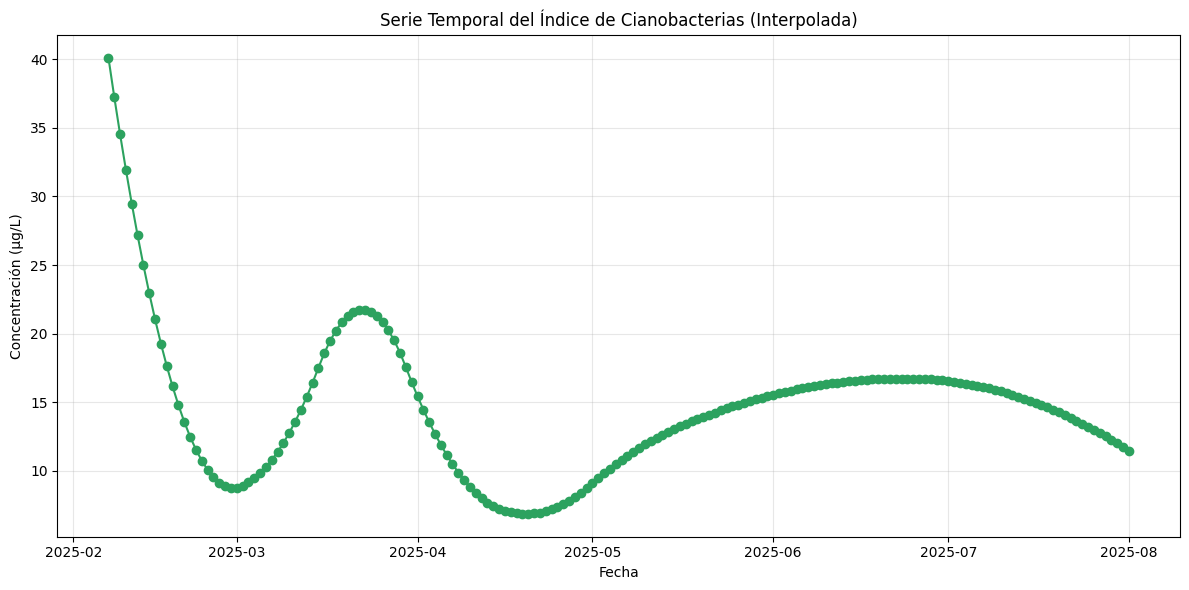

In [ ]:
# Utilizar una serie temporal par predecir el índice de cianobacteria

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import seaborn as sns

# Crear DataFrame los datos existentes
df_cian = pd.DataFrame.from_dict(promedios_attilan, orient='index', columns=['indice_cian'])
df_cian.index = pd.to_datetime(df_cian.index)

# Como tenemos pocos puntos, es importante interpolar para tener una serie más continua
# interpolacion será útil
ts = df_cian['indice_cian'].asfreq('D').interpolate(method='quadratic')

# Visualización inicial
plt.figure(figsize=(12, 6))
plt.plot(ts, marker='o', linestyle='-', color='#2ca25f')
plt.title('Serie Temporal del Índice de Cianobacterias (Interpolada)')
plt.ylabel('Concentración (µg/L)')
plt.xlabel('Fecha')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


La interpolación fue de 30 días, para poder hacer una serie temporal de predicción de un mes.

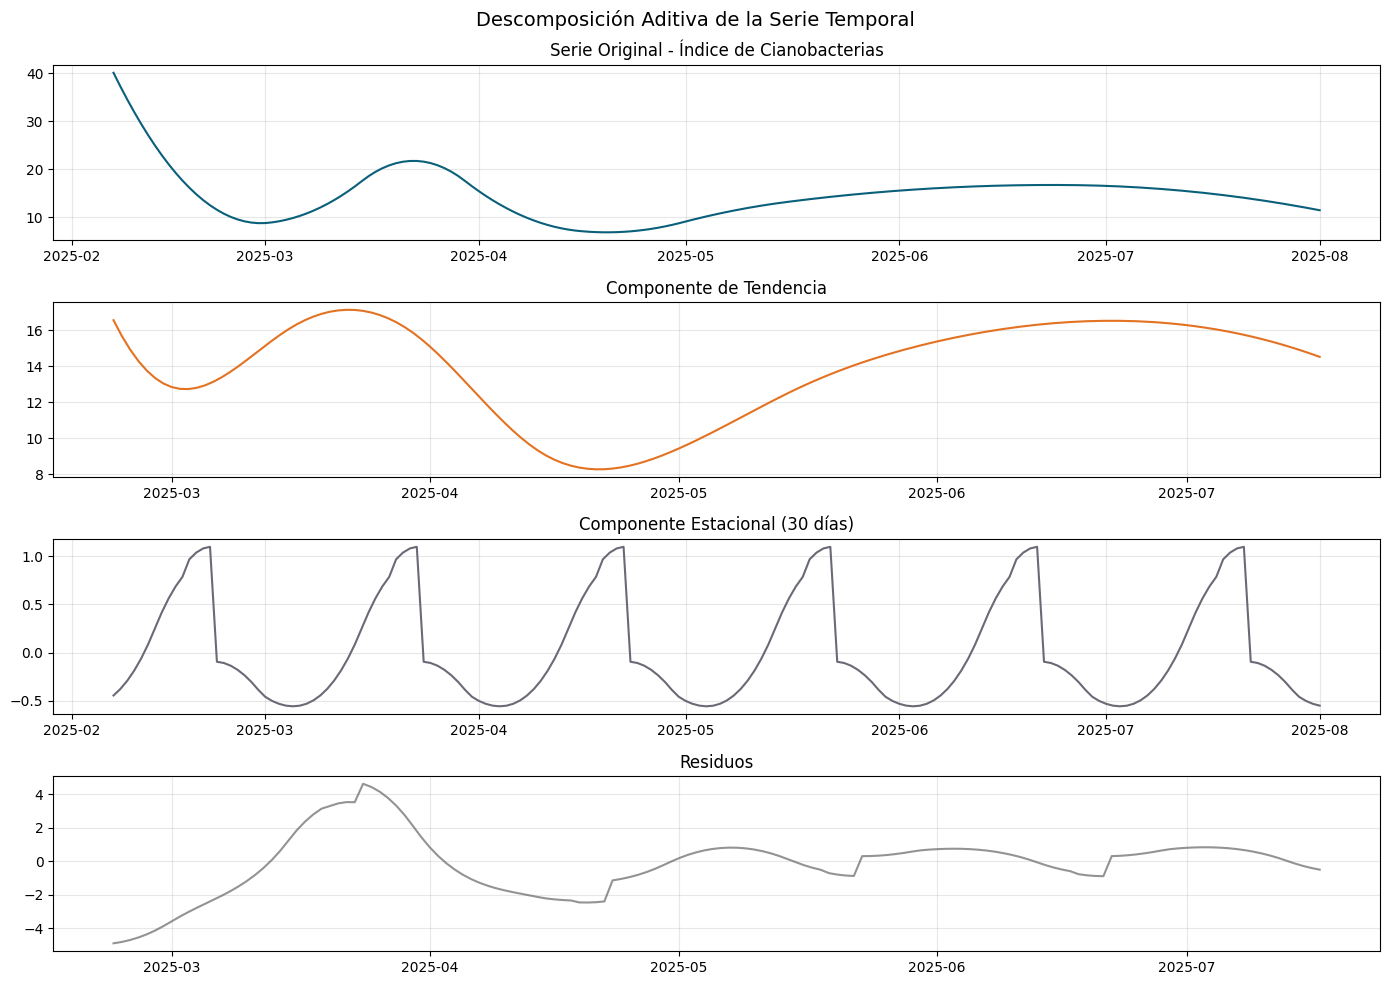

In [ ]:

# Como no tenemos un año completo de datos, usaremos un periodo más corto (ej. 30 días)
try:
    result = seasonal_decompose(ts, model='additive', period=30)

    # Visualización mejorada
    plt.figure(figsize=(14, 10))

    # Serie Original
    plt.subplot(4, 1, 1)
    plt.plot(result.observed, color='#0A5F7A')
    plt.title('Serie Original - Índice de Cianobacterias', fontsize=12)
    plt.grid(alpha=0.3)

    # Tendencia
    plt.subplot(4, 1, 2)
    plt.plot(result.trend, color='#E37222')
    plt.title('Componente de Tendencia', fontsize=12)
    plt.grid(alpha=0.3)

    # Estacionalidad
    plt.subplot(4, 1, 3)
    plt.plot(result.seasonal, color='#6D6875')
    plt.title('Componente Estacional (30 días)', fontsize=12)
    plt.grid(alpha=0.3)

    # Residuos
    plt.subplot(4, 1, 4)
    plt.plot(result.resid, color='#666666', alpha=0.7)
    plt.title('Residuos', fontsize=12)
    plt.grid(alpha=0.3)

    plt.suptitle('Descomposición Aditiva de la Serie Temporal', fontsize=14)
    plt.tight_layout()
    plt.show()

except ValueError as e:
    print(f"Error en descomposición: {e}\nProbablemente debido a pocos puntos de datos.")
    print("Considera recolectar más datos o usar un periodo más corto para la estacionalidad.")

Para poder realizar la serie de tiempo es importante tener en cuenta la estacionaridad y estacionalidad. Viendo la descomposición de la serie se puede ver que en efecto si hay estacionalidad, de hecho de un mes aproximadamente. Ahora en el caso de la estacionaridad parece que si hay cierta tendencia a que se reduzca el índice de cianobacteria por lo que es necesario confirmar con la prueba de Dickey Fuller.


Prueba para serie original:


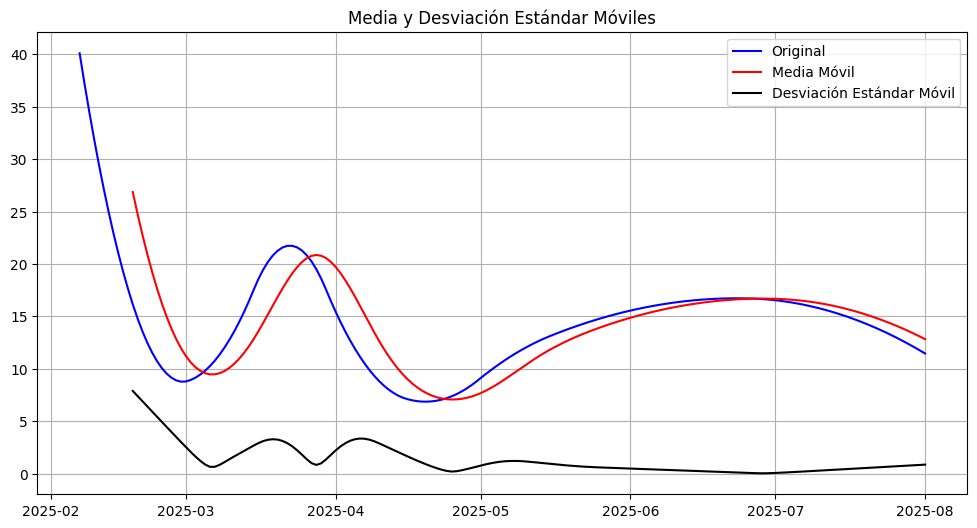

Resultados de la prueba Dickey-Fuller:
Estadístico de prueba       -3.271582
p-value                      0.016198
#Lags usado                  6.000000
Número de observaciones    169.000000
Valor crítico (1%)          -3.469648
Valor crítico (5%)          -2.878799
Valor crítico (10%)         -2.575971
dtype: float64

Conclusión: La serie es ESTACIONARIA (rechazamos la hipótesis nula)


In [ ]:
# pureba dickey fuller para estacionariedad
def test_stationarity(timeseries, window=12):
    # Determinar estadísticas móviles
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()

    # Visualizar
    plt.figure(figsize=(12, 6))
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Media Móvil')
    std = plt.plot(rolstd, color='black', label='Desviación Estándar Móvil')
    plt.legend(loc='best')
    plt.title('Media y Desviación Estándar Móviles')
    plt.grid(True)
    plt.show()

    # Realizar prueba Dickey-Fuller
    print('Resultados de la prueba Dickey-Fuller:')
    dftest = adfuller(timeseries.dropna(), autolag='AIC')  # AIC para selección automática de lags
    dfoutput = pd.Series(dftest[0:4], index=['Estadístico de prueba', 'p-value',
                                           '#Lags usado', 'Número de observaciones'])
    for key, value in dftest[4].items():
        dfoutput['Valor crítico (%s)'%key] = value
    print(dfoutput)

    # Interpretación
    if dfoutput['p-value'] < 0.05:
        print("\nConclusión: La serie es ESTACIONARIA (rechazamos la hipótesis nula)")
    else:
        print("\nConclusión: La serie NO ES ESTACIONARIA (no podemos rechazar la hipótesis nula)")

# Aplicar la prueba a la serie original
print("\nPrueba para serie original:")
test_stationarity(ts)

# Si no es estacionaria, probamos con diferenciación
if adfuller(ts.dropna())[1] > 0.05:
    print("\nProbando con primera diferenciación:")
    ts_diff = ts.diff().dropna()
    test_stationarity(ts_diff)

    # Si aún no es estacionaria, probamos con segunda diferenciación
    if adfuller(ts_diff.dropna())[1] > 0.05:
        print("\nProbando con segunda diferenciación:")
        ts_diff2 = ts_diff.diff().dropna()
        test_stationarity(ts_diff2)

Aunque el resultado con el p-value muestra que la serie es estacionario, esto se puede volver a verificar usando los graficos de ACF y PACF.

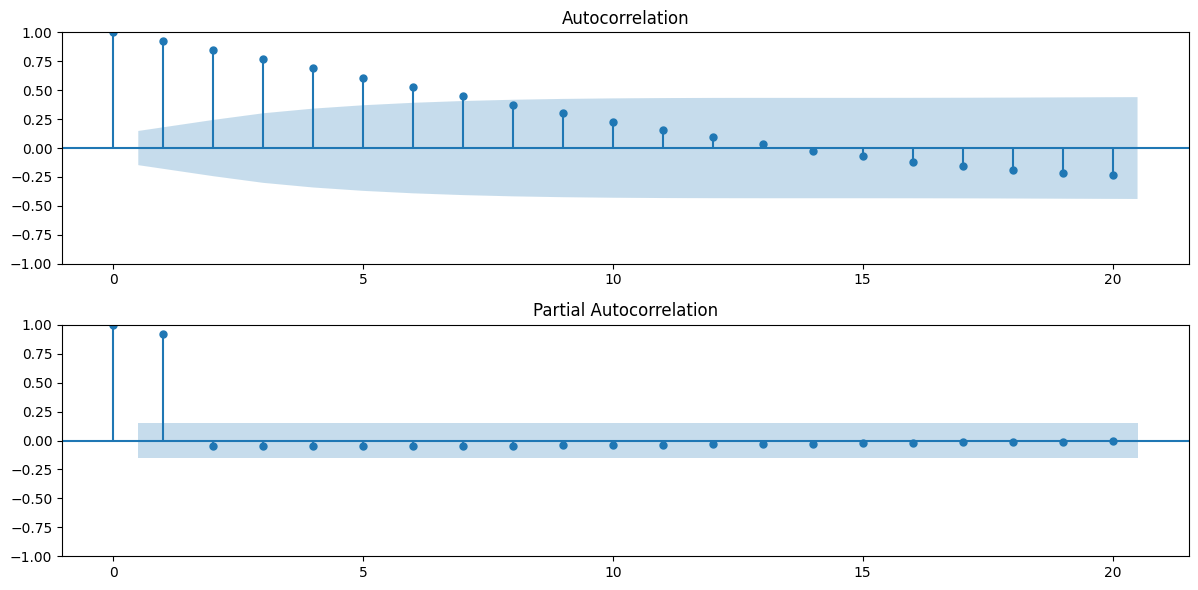

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Graficar ACF y PACF
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(ts.dropna(), ax=plt.gca(), lags=20)
plt.subplot(212)
plot_pacf(ts.dropna(), ax=plt.gca(), lags=20)
plt.tight_layout()
plt.show()

# Para la serie diferenciada (si fue necesario)
if 'ts_diff' in locals() and len(ts_diff) > 0:
    plt.figure(figsize=(12, 6))
    plt.subplot(211)
    plot_acf(ts_diff.dropna(), ax=plt.gca(), lags=20)
    plt.subplot(212)
    plot_pacf(ts_diff.dropna(), ax=plt.gca(), lags=20)
    plt.tight_layout()
    plt.show()

In [ ]:
from statsmodels.tsa.stattools import acf, pacf
import pandas as pd

# Calcular ACF y PACF con intervalos de confianza
lags = 20
alpha = 0.05

# ACF
acf_values, acf_confint = acf(ts.dropna(), nlags=lags, alpha=alpha, fft=False)
acf_df = pd.DataFrame({
    'Lag': range(lags+1),
    'ACF': acf_values,
    'Lower_CI': acf_confint[:, 0] - acf_values,
    'Upper_CI': acf_confint[:, 1] - acf_values
})

# PACF
pacf_values, pacf_confint = pacf(ts.dropna(), nlags=lags, alpha=alpha)
pacf_df = pd.DataFrame({
    'Lag': range(lags+1),
    'PACF': pacf_values,
    'Lower_CI': pacf_confint[:, 0] - pacf_values,
    'Upper_CI': pacf_confint[:, 1] - pacf_values
})

# Mostrar valores significativos, osea los que superan los intervalos de confianza)
print("Valores de ACF significativos (|ACF| > CI):")
print(acf_df[(acf_df['ACF'].abs() > abs(acf_df['Lower_CI']))][['Lag', 'ACF']])

print("\nValores de PACF significativos (|PACF| > CI):")
print(pacf_df[(pacf_df['PACF'].abs() > abs(pacf_df['Lower_CI']))][['Lag', 'PACF']])

Valores de ACF significativos (|ACF| > CI):
   Lag       ACF
0    0  1.000000
1    1  0.923900
2    2  0.846453
3    3  0.767963
4    4  0.688814
5    5  0.609456
6    6  0.530395
7    7  0.452180

Valores de PACF significativos (|PACF| > CI):
   Lag     PACF
0    0  1.00000
1    1  0.92918


Haciendo los gráficos de PACF y ACF podemos determinar los parámetros de p y q. El valor de d sabemos que puede ser 0 ya que la serie es estacionaria y tiene estacionalidad. Evaluando la gráfica PACF podemos tomar el valor p = 1, ya qu es cuando se tiene un pico y luego baja a 0. En el caso de ACF se tiene un situaión interesante, ya que el decaimiento lento contradice la prueba Dickey Fuller. Este decaimiento puede implicar que no hay estacionalidad, lo mejor es probar con un valro de q = 0:
* p = 1
* q = 0
* d = 0

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

model_ar = ARIMA(ts, order=(1, 0, 0))
results_ar = model_ar.fit()
print(results_ar.summary())

                               SARIMAX Results                                
Dep. Variable:            indice_cian   No. Observations:                  176
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -189.388
Date:                Sun, 17 Aug 2025   AIC                            384.776
Time:                        03:50:34   BIC                            394.287
Sample:                    02-07-2025   HQIC                           388.633
                         - 08-01-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         24.6566     13.315      1.852      0.064      -1.440      50.753
ar.L1          0.9987      0.006    168.214      0.000       0.987       1.010
sigma2         0.4869      0.031     15.464      0.0

El modelo ARIMA(1,0,0) inicial mostró serias limitaciones en su capacidad predictiva. Aunque el componente AR(1) fue altamente significativo (p-value ≈ 0.000), su coeficiente de 0.9987 (cercano a 1) indicaba un riesgo de sobreajuste o no estacionariedad residual, contradiciendo parcialmente la prueba Dickey-Fuller que había sugerido estacionariedad.

Además, los residuos presentaban autocorrelación no capturada (Ljung-Box p-value=0.00) y heteroscedasticidad (Prob(H)=0.00). Estos problemas, sumados a un AIC elevado (384.776), señalaban que el modelo era demasiado simplista para capturar la dinámica de las cianobacterias, especialmente dada la interpolación cuadrática aplicada a los datos. Por la naturaleza de los datos y dado que algunas pruebas se contradicecn, el mejor aprroach que se nos ocurre es hacer un proceso de tunning semi automático para encontrar valores óptimos para el modelo. Esto permitió evaluar sistemáticamente combinaciones de parámetros (p, d, q).

In [ ]:
import itertools
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

# Rango de parámetros a evaluar
p = d = q = range(0, 3)  # Valores hasta ARIMA(2,2,2)
best_aic = float("inf")
best_model = None

for params in itertools.product(p, d, q):
    try:
        model = ARIMA(ts, order=params).fit()
        if model.aic < best_aic:
            best_aic = model.aic
            best_model = model
            best_params = params
    except:
        continue

print(f"Mejor modelo ARIMA{best_params} - AIC:{best_aic}")
print(best_model.summary())

Mejor modelo ARIMA(1, 2, 1) - AIC:-997.013446167692
                               SARIMAX Results                                
Dep. Variable:            indice_cian   No. Observations:                  176
Model:                 ARIMA(1, 2, 1)   Log Likelihood                 501.507
Date:                Sun, 17 Aug 2025   AIC                           -997.013
Time:                        03:50:45   BIC                           -987.536
Sample:                    02-07-2025   HQIC                          -993.169
                         - 08-01-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9361      0.025     37.881      0.000       0.888       0.985
ma.L1          0.8141      0.045     18.166      0.000       0.726       0.902


El modelo ARIMA(1,2,1) terminó siendo el mejor candidato. Con un AIC de -997, es significativamente menor que el modelo inicial. Además tiene residuos sin autocorrelación (Ljung-Box p-value=0.89). Los coeficientes AR(1) (0.9361) y MA(1) (0.8141) fueron estadísticamente significativos (p-value=0.000), indicando que la serie combina memoria de sus valores pasados (AR) y reacciones a shocks recientes (MA). La razón por la que realmente ha sido más elabodorado elegir los parámetros se debe principalmente a la cantidad de datos iniciales, ya que no teníamos tantas imagenes satelitales debido a la nubosidad y/o imagenes con errores es que la selección de parámetros del modelo se ha hecho compleja. Ahora que ya tenemos el mejor modelo, podemos realizar la predicción del índice de cianobacteria.

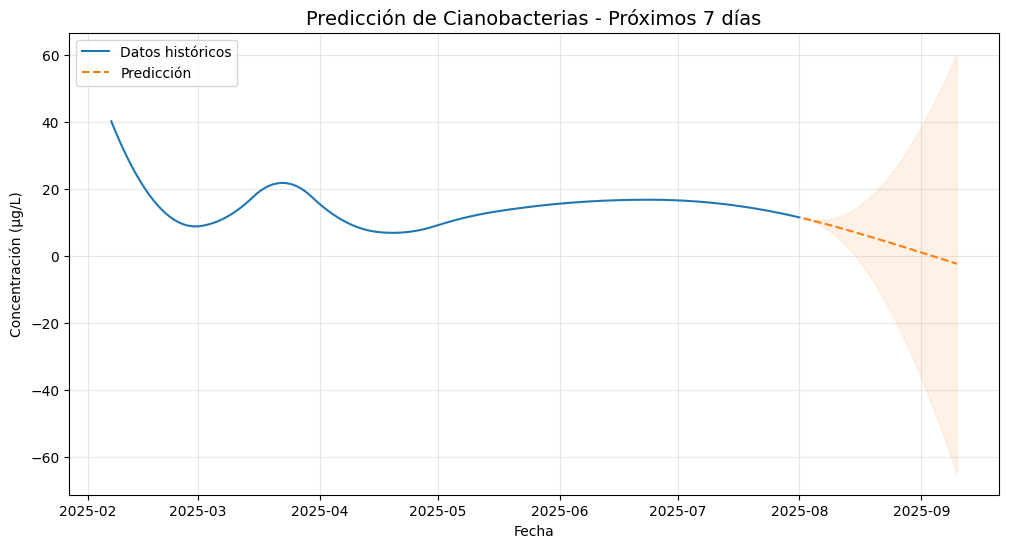

In [ ]:
# Generar predicciones para los próximos 40 días
forecast_steps = 40
forecast = best_model.get_forecast(steps=forecast_steps)

# Obtener intervalo de confianza
pred_df = forecast.conf_int()
pred_df['Predicción'] = forecast.predicted_mean

# Visualización
plt.figure(figsize=(12, 6))
plt.plot(ts, label='Datos históricos', color='#1f77b4')
plt.plot(pred_df['Predicción'], label='Predicción', color='#ff7f0e', linestyle='--')
plt.fill_between(pred_df.index,
                pred_df['lower indice_cian'],
                pred_df['upper indice_cian'],
                color='#ff7f0e', alpha=0.1)
plt.title('Predicción de Cianobacterias - Próximos 7 días', fontsize=14)
plt.ylabel('Concentración (µg/L)')
plt.xlabel('Fecha')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Luego de haber encontrado la mejor combinación este fue el modelo resultante. Podemos hacer distintas observaciones sobre esto. Primero que nada hablando sobre la predicción del siguiente mes, parece que la tendencia es que la cantidad de cianobacterias disminuya un poco más, lo cuál es una buena señal para la condición del lago. Ahora es muy importante mencionar que el intervalo de confianza par ala predicción es demasiado grande e indica que hay mucha incertidumbre en si realmente va a subir o bajar. Encontrar los parámetros adecyados para la serie fue complicado y aun haciendolo con tunning no se obtuvieron los mejores resultados posibles. Seguramente se deba a la naturaleza de los datos, ya que no se tenían suficientes datos y se tuvieron que interpolar, esto pudo haber afectado significativamente el desempeño.

Ahora bien, con los datos y proceimientos realizados hasta el momento, es posible hacer más análisis. Ahora lo que se propone es hacer uso de un modelo de clasificación para poder determinar sin un pixel de la imagen tiene altos niveles de cianobacteria o no, una clasificación binaria prácticamente. Para poder transofrmar la situación en un problema de clasificación se propuso colocar un threshold de 10 ug/L, si es má de eso se clasifica como presencia de cianobacteria alta.


Iniciando procesamiento de 3 imágenes (muestreo=10.0% de píxeles)...

[Imagen 1/3] 2025-02-07 

(Píxeles a procesar: 82958) ✓ Completado (Muestras totales: 82958)

[Imagen 2/3] 2025-02-27 

(Píxeles a procesar: 201662) 

✓ Completado (Muestras totales: 284620)

[Imagen 3/3] 2025-03-04 (Píxeles a procesar: 130601) ✓ Completado (Muestras totales: 415221)

Procesamiento finalizado!

Dividiendo datos en train/test...
Entrenando Random Forest...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   42.2s


building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.9min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.5s



EVALUACIÓN DEL MODELO DE CLASIFICACIÓN DE PÍXELES

MATRIZ DE CONFUSIÓN:


[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    1.3s finished


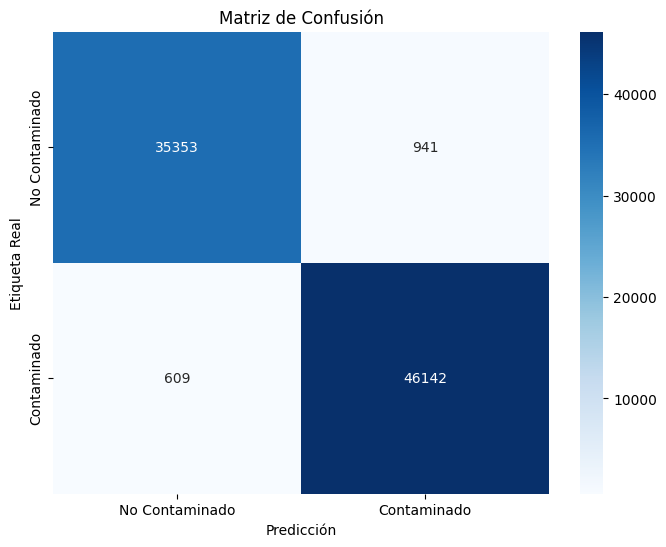

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.



REPORTE DE CLASIFICACIÓN:
                precision    recall  f1-score   support

No Contaminado       0.98      0.97      0.98     36294
   Contaminado       0.98      0.99      0.98     46751

      accuracy                           0.98     83045
     macro avg       0.98      0.98      0.98     83045
  weighted avg       0.98      0.98      0.98     83045


RESUMEN DE RESULTADOS:


[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    2.0s finished


- Accuracy: 0.9813
- Precisión (Contaminado): 0.9800
- Recall (Contaminado): 0.9870
- Muestras totales: 415221
- Distribución de clases: [180943 234278]
  • No contaminado (0): 180943
  • Contaminado (1): 234278

TOP 5 CARACTERÍSTICAS MÁS IMPORTANTES:
B04: 0.2645
B05: 0.2441
B11: 0.1356
B12: 0.0860
B02: 0.0824


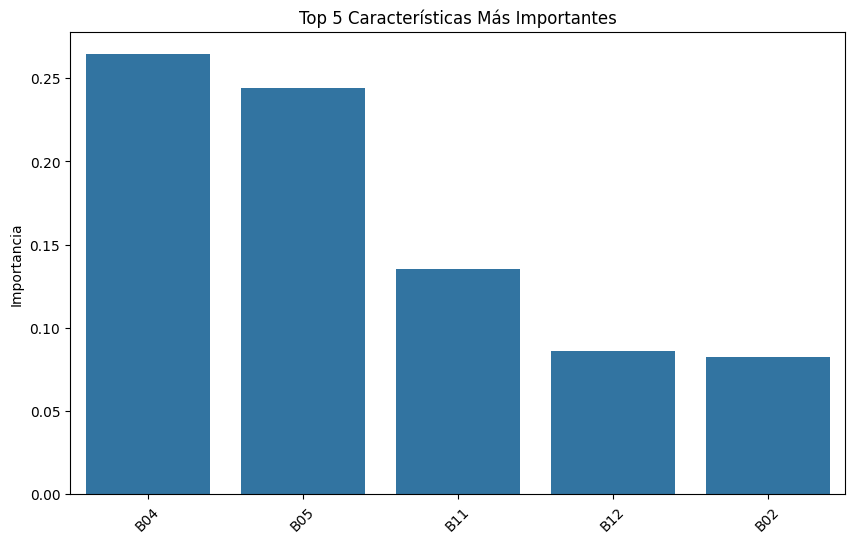

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import rasterio
from tqdm import tqdm
import warnings
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Configuración
umbral_contaminacion = 10  # µg/L
max_imagenes = 3  # cantidad de imagenes
muestreo_pixeles = 0.1  # Fracción de píxeles a muestrar

# Suprimir warnings específicos de rasterio
warnings.filterwarnings("ignore", category=UserWarning, module="rasterio")

def preparar_datos_clasificacion_final(datos_cian, max_imagenes=None, muestreo=1.0):
    X, y = [], []
    fechas = list(datos_cian.keys())

    if max_imagenes is not None:
        fechas = fechas[:max_imagenes]

    print(f"\nIniciando procesamiento de {len(fechas)} imágenes (muestreo={muestreo*100}% de píxeles)...")

    for i, fecha in enumerate(fechas, 1):
        print(f"\n[Imagen {i}/{len(fechas)}] {fecha}", end=" ")
        arr = datos_cian[fecha]['array']
        rows, cols = np.where(arr > 0)  # Máscara de agua

        # Muestreo aleatorio eficiente
        if muestreo < 1.0:
            n_muestras = int(len(rows) * muestreo)
            idx = np.random.choice(len(rows), size=n_muestras, replace=False)
            rows, cols = rows[idx], cols[idx]

        print(f"(Píxeles a procesar: {len(rows)})", end=" ")

        try:
            with rasterio.open(f"Atitlan_bands_{fecha.replace('-','')}.tif") as src:
                # Leer todas las bandas de una vez para mejor performance
                band_data = src.read()

                # Procesamiento silencioso de píxeles
                for r, c in zip(rows, cols):
                    X.append([r, c, *band_data[:, r, c]])
                    y.append(1 if arr[r,c] > umbral_contaminacion else 0)

            print(f"✓ Completado (Muestras totales: {len(X)})")

        except Exception as e:
            print(f"✗ Error: {str(e)}")
            continue

    print("\nProcesamiento finalizado!")
    return np.array(X), np.array(y)

# Ejecución del procesamiento
X, y = preparar_datos_clasificacion_final(
    datos_cian,
    max_imagenes=3,
    muestreo=0.1
)


if len(X) > 0:
    print("\nDividiendo datos en train/test...")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    print("Entrenando Random Forest...")
    clf = RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        verbose=2,
        n_jobs=-1
    )
    clf.fit(X_train, y_train)

    # Predicciones en el conjunto de prueba
    y_pred = clf.predict(X_test)

    print("\n" + "="*60)
    print("EVALUACIÓN DEL MODELO DE CLASIFICACIÓN DE PÍXELES")
    print("="*60)

    # Matriz de confusión
    print("\nMATRIZ DE CONFUSIÓN:")
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Contaminado', 'Contaminado'],
                yticklabels=['No Contaminado', 'Contaminado'])
    plt.title('Matriz de Confusión')
    plt.ylabel('Etiqueta Real')
    plt.xlabel('Predicción')
    plt.show()

    #Reporte de clasificación
    print("\nREPORTE DE CLASIFICACIÓN:")
    print(classification_report(y_test, y_pred,
                               target_names=['No Contaminado', 'Contaminado']))

    #Métricas adicionales
    print("\nRESUMEN DE RESULTADOS:")
    print(f"- Accuracy: {clf.score(X_test, y_test):.4f}")
    print(f"- Precisión (Contaminado): {cm[1,1]/(cm[1,1]+cm[0,1]):.4f}")
    print(f"- Recall (Contaminado): {cm[1,1]/(cm[1,1]+cm[1,0]):.4f}")
    print(f"- Muestras totales: {len(X)}")
    print(f"- Distribución de clases: {np.bincount(y)}")
    print(f"  • No contaminado (0): {np.bincount(y)[0]}")
    print(f"  • Contaminado (1): {np.bincount(y)[1]}")


    print("\nTOP 5 CARACTERÍSTICAS MÁS IMPORTANTES:")
    feature_names = ['Fila', 'Columna', 'B02', 'B03', 'B04', 'B05', 'B08', 'B11', 'B12']
    importancias = clf.feature_importances_
    indices = np.argsort(importancias)[::-1][:5]

    for i in indices:
        print(f"{feature_names[i]}: {importancias[i]:.4f}")

    # Visualización de importancia de características
    plt.figure(figsize=(10,6))
    sns.barplot(x=[feature_names[i] for i in indices],
                y=importancias[indices])
    plt.title('Top 5 Características Más Importantes')
    plt.ylabel('Importancia')
    plt.xticks(rotation=45)
    plt.show()

else:
    print("\nNo se procesaron datos válidos. Verifica:")
    print("- Que los archivos .tif existan")
    print("- Que datos_cian contenga información")
    print("- Que haya píxeles con valores > 0")

In [ ]:
from joblib import dump

# Guardar el modelo
model_filename = '/content/drive/MyDrive/modelo_cianobacterias.joblib'
dump(clf, model_filename)

print(f"Modelo guardado en: {model_filename}")

Modelo guardado en: /content/drive/MyDrive/modelo_cianobacterias.joblib


Nuestro modelo de clasificación es un Random Forest diseñado para detectar si un píxel en una imagen de satélite del lago contiene niveles altos de cianobacterias. El umbral lo definimos como una concentración igual o superior a 10 µg/L. Para realizar esta predicción, el modelo se basa en dos tipos de características: espaciales y espectrales. Las características espaciales incluyen las coordenadas de cada píxel, lo que le permite al modelo identificar patrones geográficos, como la mayor contaminación cerca de las orillas. Las características espectrales son los valores de siete bandas de la imagen satelital Sentinel-2 (B02, B03, B04, B05, B08, B11, B12). A través del entrenamiento, el modelo ha aprendido que ciertas combinaciones de estas bandas, particularmente las de los rangos rojo e infrarrojo, tienen una fuerte correlación con la concentración de cianobacterias.

Al combinar estas características espaciales y espectrales, el Random Forest es capaz de predecir con precisión la contaminación, clasificando como "contaminado" (1) cualquier píxel que supere el umbral científico de 10 µg/L. Al final se ha tenido un desempeño bastante bueno, llegando a alcanzar un accuracy de 0.98. Es importante mencionar que para el entrenamiento no se han utilizado todas las imágenes por fines de practicidad, pero de igual manera al estar los datos de contaminado y no contaminado, balanceados, podemos ver que no fue necesario usar todas las imagenes. Con 1 imagen fue suficiente para poder tener más de 400k datos. Podemos ver que no solo el accuracy es bueno, sino también el recall es de 0.97 y el f1-score 0.98, lo cuál indica un modelo que clasifica bastante bien ambas clases.

Algo interesante es que la relevancia de las bandas se puede notar en este primer modelo. En el caso de la banda B04 es la que tuvo mayor importancia para clasificar un pixel. Esto tiene sentido si se toma en cuenta que esta banda es capaz de detectar la absorción máximo de clorofila-a algo que ya hemos demostrado tiene bastante relación con la presencia de cianobacterias junto con la banda B05 también.

# Modelo híbrido

Con este modelo lo que se intenta encontrar es cuales variables resultan tener influencia para la generación de cianobacteria y de igual manera predecir sobre los pixeles del lago. Así al final también se pueden hacer comparaciones con el modelo anterior. El data frame que se genera a continuación se hace con la información de la siguiente página web:

https://weatherspark.com/compare/y/11701~11135/Comparison-of-the-Average-Weather-in-Amatitl%C3%A1n-and-Santiago-Atitl%C3%A1n#google_vignette

Eso si, la información diaría y los csv eran de pago, entonces utilizamos la información gratuita que se ve al abrir la página. Debajo de las imágenes se proporciona una tabla con los datos mensuales en promedio por región y los datos elegidos son de temepraturas altas, bajas, precipitación y humedad. Ojo, la información de las tablas es de "Santiago Atitlán", no especificamente de atitlan, por lo que la información puede afectar lso reusltados al ser menos precisa.

In [ ]:
# creacion de df

import pandas as pd

# Datos de temperatura alta (°F)
temp_alta = {
    'Jan': 73, 'Feb': 75, 'Mar': 77, 'Apr': 77, 'May': 76,
    'Jun': 74, 'Jul': 74, 'Aug': 74, 'Sep': 73, 'Oct': 73,
    'Nov': 73, 'Dec': 73
}

# Datos de temperatura baja (°F)
temp_baja = {
    'Jan': 50, 'Feb': 51, 'Mar': 53, 'Apr': 55, 'May': 58,
    'Jun': 58, 'Jul': 57, 'Aug': 57, 'Sep': 57, 'Oct': 55,
    'Nov': 53, 'Dec': 51
}

# Precipitación (pulgadas)
precipitacion = {
    'Jan': 0.1, 'Feb': 0.2, 'Mar': 0.7, 'Apr': 2.0, 'May': 5.5,
    'Jun': 9.2, 'Jul': 7.9, 'Aug': 8.4, 'Sep': 10.1, 'Oct': 7.4,
    'Nov': 2.3, 'Dec': 0.4
}

# Días húmedos
dias_humedos = {
    'Jan': 0.0, 'Feb': 0.0, 'Mar': 0.0, 'Apr': 0.2, 'May': 0.7,
    'Jun': 0.5, 'Jul': 0.1, 'Aug': 0.1, 'Sep': 0.2, 'Oct': 0.2,
    'Nov': 0.1, 'Dec': 0.0
}

# Crear DataFrame
clima_atitlan = pd.DataFrame({
    'Temp_Alta': temp_alta,
    'Temp_Baja': temp_baja,
    'Precipitacion': precipitacion,
    'Dias_Humedos': dias_humedos
})

# Convertir a Celsius
clima_atitlan['Temp_Alta_C'] = (clima_atitlan['Temp_Alta'] - 32) * 5/9
clima_atitlan['Temp_Baja_C'] = (clima_atitlan['Temp_Baja'] - 32) * 5/9

In [ ]:
#Obtiene datos climáticos para una fecha específica
def obtener_clima(fecha):
    mes = fecha.strftime('%b') if hasattr(fecha, 'strftime') else fecha.split('-')[1]
    mes = {
        '01': 'Jan', '02': 'Feb', '03': 'Mar', '04': 'Apr',
        '05': 'May', '06': 'Jun', '07': 'Jul', '08': 'Aug',
        '09': 'Sep', '10': 'Oct', '11': 'Nov', '12': 'Dec'
    }.get(mes, mes)

    return clima_atitlan.loc[mes]

In [ ]:
# integrando los datos nuevos a la informacion previamente obtenida de cianobacteria y retornando X,y para entrenamiento
def preparar_datos_hibridos_completo(datos_cian, max_imagenes=None, muestreo=1.0):
    X, y = [], []
    fechas = list(datos_cian.keys())

    if max_imagenes is not None:
        fechas = fechas[:max_imagenes]

    print(f"\nPreparando datos híbridos completos para {len(fechas)} imágenes...")

    for fecha in tqdm(fechas, desc="Procesando imágenes"):
        arr = datos_cian[fecha]['array']
        rows, cols = np.where(arr > 0)

        if muestreo < 1.0:
            n_muestras = int(len(rows) * muestreo)
            idx = np.random.choice(len(rows), size=n_muestras, replace=False)
            rows, cols = rows[idx], cols[idx]

        try:
            # Obtener datos climáticos para esta fecha
            clima = obtener_clima(fecha)

            with rasterio.open(f"Atitlan_bands_{fecha.replace('-','')}.tif") as src:
                band_data = src.read()

                # Predicción temporal del modelo ARIMA
                indice_temporal = best_model.predict(fecha)[0]

                for r, c in zip(rows, cols):
                    # Características ampliadas:
                    # 1. Datos originales (coordenadas + bandas)
                    # 2. Predicción temporal
                    # 3. Variables climáticas
                    X.append([
                        r, c,                             # Coordenadas
                        *band_data[:, r, c],              # Bandas espectrales (B02-B12)
                        indice_temporal,                  # Predicción ARIMA
                        clima['Temp_Alta'],               # Temperatura alta (°F)
                        clima['Temp_Baja'],               # Temperatura baja (°F)
                        clima['Precipitacion'],           # Precipitación (pulgadas)
                        clima['Dias_Humedos'],            # Días húmedos
                    ])
                    y.append(1 if arr[r,c] > umbral_contaminacion else 0)

        except Exception as e:
            print(f"\nError en {fecha}: {str(e)}")
            continue

    return np.array(X), np.array(y)

# Entrenamiento del modelo hibrido

Nuevamente se hace un modelo random forest


Preparando datos híbridos completos para 3 imágenes...


Procesando imágenes: 100%|██████████| 3/3 [00:07<00:00,  2.58s/it]



Entrenando modelo híbrido completo...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   59.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.0min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.



Evaluación del Modelo Híbrido Completo:


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.3s


Accuracy: 0.82


[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.7s finished


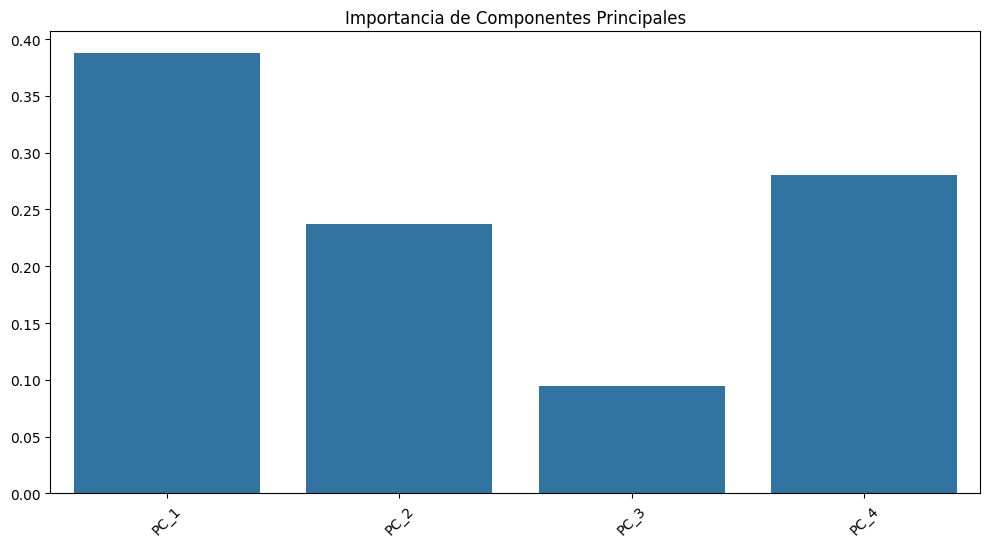

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA

# Generar datos aumentados
X_hib, y_hib = preparar_datos_hibridos_completo(datos_cian, max_imagenes=3, muestreo=0.1)

if len(X_hib) > 0:
    # Dividir datos
    X_train, X_test, y_train, y_test = train_test_split(X_hib, y_hib, test_size=0.2, random_state=42)

    # Nuevos nombres de características
    feature_names = [
        'Fila', 'Columna',
        'B02', 'B03', 'B04', 'B05', 'B08', 'B11', 'B12',
        'Indice_Temporal',
        'Temp_Alta_F',
        'Temp_Baja_F',
        'Precipitacion_in',
        'Dias_Humedos',
        'TempAlta_x_Precip',
        'TempBaja_x_DiasHum'
    ]



    pipe_hibrido_completo = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=0.95)),  # Reducción dimensional
        ('clf', RandomForestClassifier(
            n_estimators=100, # la misma cantidad de arboles
            max_depth=12,
            min_samples_split=5,
            class_weight='balanced',
            random_state=42,
            n_jobs=-1,
            verbose=1
        ))
    ])

    # Entrenamiento
    print("\nEntrenando modelo híbrido completo...")
    pipe_hibrido_completo.fit(X_train, y_train)

    # Evaluación
    print("\nEvaluación del Modelo Híbrido Completo:")
    print(f"Accuracy: {pipe_hibrido_completo.score(X_test, y_test):.2f}")

    # Importancia de características
    importancias = pipe_hibrido_completo.named_steps['clf'].feature_importances_
    # Ajustar nombres por PCA
    nombres_pca = [f"PC_{i+1}" for i in range(len(importancias))]

    plt.figure(figsize=(12, 6))
    sns.barplot(x=nombres_pca, y=importancias)
    plt.title('Importancia de Componentes Principales')
    plt.xticks(rotation=45)
    plt.show()

En este desglose se puede ver que hubo cierta reducción de parámetros por la prueba PCA. Más adelante se ve el resultado y que representa cada una de estas.

Número de características originales: 16
Dimensiones de pca.components_: (4, 14)
Advertencia: feature_names tiene 16 elementos pero PCA usó 14

Matriz de Loadings PCA completa:
                      PC_1      PC_2      PC_3      PC_4
Fila              0.238911  0.029273  0.181278 -0.272351
Columna          -0.112686  0.020706  0.976709  0.127429
B02               0.359237  0.041603  0.020788 -0.009137
B03               0.359298  0.042753  0.021156 -0.015698
B04               0.358564  0.044922  0.024311 -0.022981
B05               0.359011  0.043185  0.022812 -0.022930
B08               0.358902  0.045899  0.029742 -0.025282
B11               0.356555  0.049911  0.041450 -0.028189
B12               0.353574  0.047743  0.043738 -0.022137
Indice_Temporal   0.090809  0.339987 -0.081306  0.898432
Temp_Alta_F      -0.092046  0.538146 -0.004495 -0.181750
Temp_Baja_F      -0.092046  0.538146 -0.004495 -0.181750
Precipitacion_in -0.092046  0.538146 -0.004495 -0.181750
Dias_Humedos      0.00000

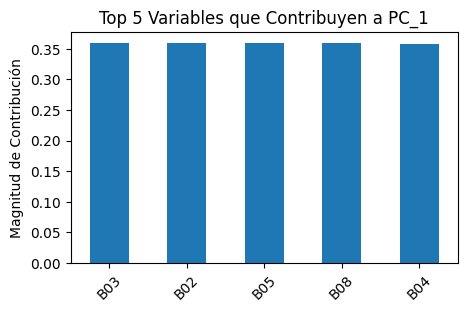

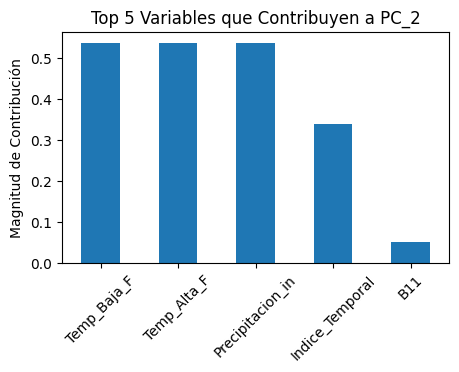

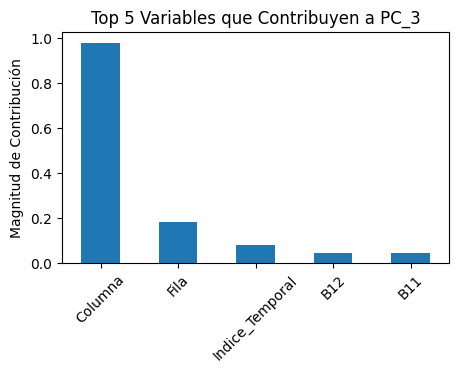

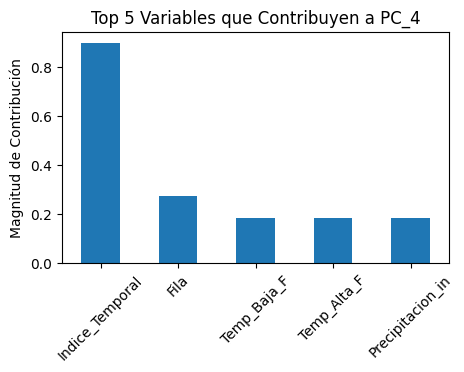

In [ ]:
# Obtener los loadings del PCA
pca = pipe_hibrido_completo.named_steps['pca']

print(f"Número de características originales: {len(feature_names)}")
print(f"Dimensiones de pca.components_: {pca.components_.shape}")

# Crear DataFrame de loadings asegurando coincidencia de dimensiones
n_components = pca.components_.shape[0]
n_features = pca.components_.shape[1]

# Tomar solo los primeros n_features nombres
if len(feature_names) > n_features:
    print(f"Advertencia: feature_names tiene {len(feature_names)} elementos pero PCA usó {n_features}")
    used_feature_names = feature_names[:n_features]
else:
    used_feature_names = feature_names

loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f"PC_{i+1}" for i in range(n_components)],
    index=used_feature_names
)


print("\nMatriz de Loadings PCA completa:")
print(loadings)

# Visualización mejorada de los loadings
#plt.figure(figsize=(12, 8))
#sns.heatmap(loadings, annot=True, cmap='coolwarm', center=0)
#plt.title('Cargas (Loadings) de las Componentes Principales')
#plt.show()

# Identificar las variables más influyentes por componente
print("\nVariables más importantes por componente:")
top_features_per_pc = loadings.abs().idxmax()
print(top_features_per_pc)

# Visualización de las contribuciones
for pc in loadings.columns:
    plt.figure(figsize=(5, 3))
    loadings[pc].abs().sort_values(ascending=False).head(5).plot(kind='bar')
    plt.title(f'Top 5 Variables que Contribuyen a {pc}')
    plt.ylabel('Magnitud de Contribución')
    plt.xticks(rotation=45)
    plt.show()

En este caso las predicciones fueron hechas principalmente por grupos de variables. Un grupo fue el de las bandas prácticamente, otro fue de factores climáticos, otro respecto a la posición y el último relacionado al tiempo (PC_1,2,3 y 4 respecticamente). Con esto se ve claramente que estos factores son los que más afectan a las predicciones pero lo que llama la atención de todo esto son 2 cosas en específico. En primero lugar, las temperaturas bajas parece que tienen relación con el índice de cianobacteria y también tiene que ver la posición. La posición se representa con las variables Columna y fila, ya que representan la posición del pixel en la pantalla, lo cuál indica que si hay mayor tendencia a haber un índice de cianobacteria más alto dependiendo de la parte del lago y también dependiendo del clima.

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.7s finished


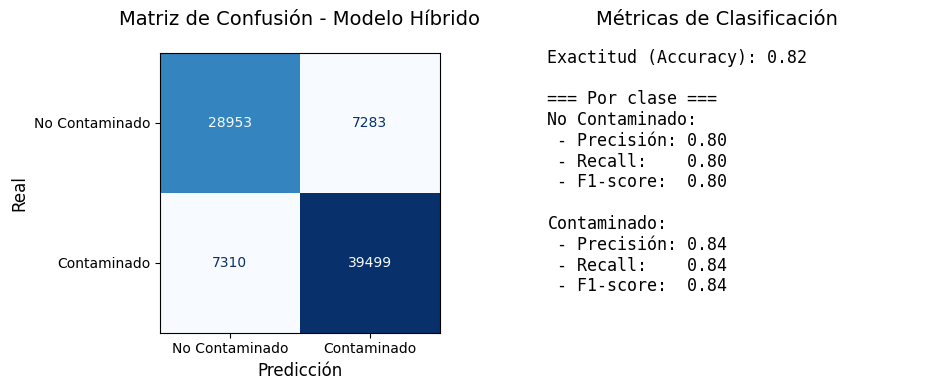

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import numpy as np

# Crear figura con dos subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Matriz de confusión
ConfusionMatrixDisplay.from_estimator(
    pipe_hibrido_completo,
    X_test,
    y_test,
    cmap='Blues',
    display_labels=['No Contaminado', 'Contaminado'],
    ax=ax1,
    colorbar=False
)
ax1.set_title('Matriz de Confusión - Modelo Híbrido', pad=20, fontsize=14)
ax1.set_xlabel('Predicción', fontsize=12)
ax1.set_ylabel('Real', fontsize=12)
ax1.grid(False)

# Métricas de clasificación
y_pred = pipe_hibrido_completo.predict(X_test)
report = classification_report(y_test, y_pred, output_dict=True, target_names=['No Contaminado', 'Contaminado'])

# Preparar texto para mostrar
metrics_text = (
    f"Exactitud (Accuracy): {report['accuracy']:.2f}\n\n"
    f"=== Por clase ===\n"
    f"No Contaminado:\n"
    f" - Precisión: {report['No Contaminado']['precision']:.2f}\n"
    f" - Recall:    {report['No Contaminado']['recall']:.2f}\n"
    f" - F1-score:  {report['No Contaminado']['f1-score']:.2f}\n\n"
    f"Contaminado:\n"
    f" - Precisión: {report['Contaminado']['precision']:.2f}\n"
    f" - Recall:    {report['Contaminado']['recall']:.2f}\n"
    f" - F1-score:  {report['Contaminado']['f1-score']:.2f}\n\n"
)

# Mostrar métricas en el segundo subplot
ax2.text(0.1, 0.5, metrics_text, fontsize=12, va='center', ha='left', family='monospace')
ax2.axis('off')
ax2.set_title('Métricas de Clasificación', pad=20, fontsize=14)

plt.tight_layout()
plt.show()

Analizando los resultados es notable que el rendimiento del modelo es considerablemente menor al modelo anterior. Al introducir nuevas variables al entrenamiento el modelo es más complejo y las relaciones entre los datos se vuelven maás complejas también. Se llegó a un máximo de 82 de accuracy utilizando la misma configuración del modelo anterior. Aunque no se mantuvo la métrica de igual forma es un buen valor y el modelo parece haber tenido un buen recall, precision y f1-score en ambas clases.

El modelo parece generalizar bien aunque tenga un menor accuracy, seguramente tengo mayor capacidad para generalizar. Además que usar más variables nos da la posibilidad de obtener más insiights para saber que factores están relacionados con la producción de cianobacterias además de las bandas y lo que estas representan.

Habiendo terminado esto, lo que queda por hacer es graficar los reusltados de las predicciones sobre el mapa del lago. para esto usamos una imagen de las varias qeu se tienen para colocar los puntos predecidos por los modelos. Elegimos la primera imagen (osea la fecha más antigua) ya que es una de las que tiene mejor definida la forma del lago.

In [ ]:
from joblib import load
import numpy as np
import rasterio
import matplotlib.pyplot as plt

# Cargar modelos guardados
modelo_rf = load('/content/drive/MyDrive/modelo_cianobacterias.joblib')
modelo_hibrido = pipe_hibrido_completo  # Asumiendo que ya está entrenado

# Cargar una imagen de ejemplo la primera por ejemplo
fecha_ejemplo = fechas_prueba[0]
with rasterio.open(f"Atitlan_bands_{fecha_ejemplo.replace('-','')}.tif") as src:
    bandas = src.read()
    meta = src.meta
    transform = src.transform

In [ ]:
def generar_mapa_prediccion(modelo, bandas, fecha, meta, nombre_archivo, datos_cian):
    """Genera mapa de predicciones aplicando correctamente la máscara de agua."""
    # Cargar máscara de agua original (donde arr > 0)
    arr = datos_cian[fecha]['array']
    rows, cols = np.where(arr > 0)  # Máscara CONSISTENTE con el entrenamiento

    # Preparar datos para predicción
    X_pred = []
    for r, c in zip(rows, cols):
        X_pred.append([r, c, *bandas[:, r, c]])

    X_pred = np.array(X_pred)

    # Predecir solo en áreas de agua
    y_pred = modelo.predict(X_pred)

    # Crear matriz de predicción (con 0=No Agua)
    pred_matrix = np.zeros_like(bandas[0], dtype=np.uint8)
    for idx, (r, c) in enumerate(zip(rows, cols)):
        pred_matrix[r, c] = y_pred[idx] + 1  # +1 para diferenciar de "No Agua"

    # Guardar
    meta.update({'count': 1, 'dtype': 'uint8', 'nodata': 0})
    with rasterio.open(nombre_archivo, 'w', **meta) as dst:
        dst.write(pred_matrix, 1)

    return pred_matrix

In [ ]:
def plot_prediccion(pred_matrix, titulo, fecha):
    """Visualización con leyenda clara y máscara de tierra."""
    # Crear máscara para tierra (0) vs agua (1-2)
    mask = np.where(pred_matrix == 0, 0, 1)

    plt.figure(figsize=(12, 8))

    # Mostrar predicciones solo en agua
    im = plt.imshow(
        np.ma.masked_where(mask == 0, pred_matrix),
        cmap='coolwarm',
        vmin=1,
        vmax=2,
        alpha=0.7
    )

    # Leyenda personalizada
    cbar = plt.colorbar(im, ticks=[1, 2])
    cbar.ax.set_yticklabels(['No Contaminado', 'Contaminado'])
    cbar.set_label('Estado del Agua')

    plt.title(f"{titulo}\nFecha: {fecha}")
    plt.axis('off')

    # Añadir máscara de tierra (opcional)
    plt.imshow(
        np.ma.masked_where(mask == 1, pred_matrix),
        cmap='Greys',
        vmin=0,
        vmax=0,
        alpha=0.3
    )

    plt.show()

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    3.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    7.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.4s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    3.0s finished


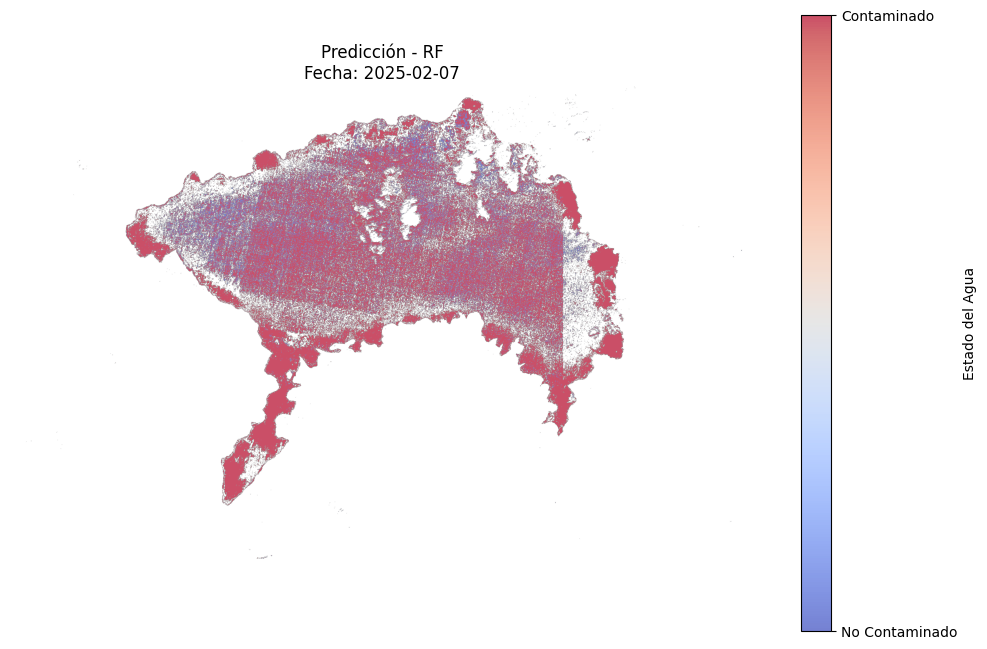

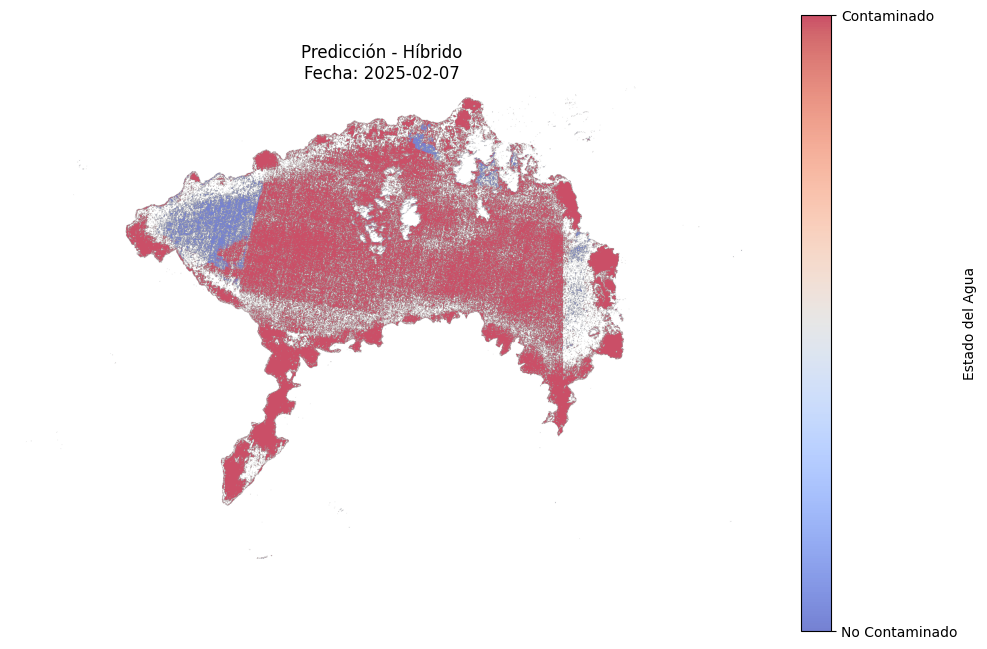

In [ ]:
# Para Random Forest
pred_rf_corr = generar_mapa_prediccion(
    modelo_rf,
    bandas,
    fecha_ejemplo,
    meta,
    f"prediccion_Random_Forest_{fecha_ejemplo.replace('-','')}.tif",
    datos_cian
)

# Para Modelo Híbrido
def generar_mapa_hibrido(modelo, bandas, fecha, meta, nombre_archivo, datos_cian):
    arr = datos_cian[fecha]['array']
    rows, cols = np.where(arr > 0)

    clima = obtener_clima(fecha)
    indice_arima = best_model.predict(fecha)[0]

    X_pred = []
    for r, c in zip(rows, cols):
        X_pred.append([
            r, c,
            *bandas[:, r, c],
            indice_arima,
            clima['Temp_Alta'],
            clima['Temp_Baja'],
            clima['Precipitacion'],
            clima['Dias_Humedos']
        ])

    X_pred = np.array(X_pred)
    y_pred = modelo.predict(X_pred)

    pred_matrix = np.zeros_like(bandas[0], dtype=np.uint8)
    for idx, (r, c) in enumerate(zip(rows, cols)):
        pred_matrix[r, c] = y_pred[idx] + 1

    meta.update({'count': 1, 'dtype': 'uint8', 'nodata': 0})
    with rasterio.open(nombre_archivo, 'w', **meta) as dst:
        dst.write(pred_matrix, 1)

    return pred_matrix

pred_hibrido_corr = generar_mapa_hibrido(
    modelo_hibrido,
    bandas,
    fecha_ejemplo,
    meta,
    f"prediccion_HIBRIDO{fecha_ejemplo.replace('-','')}.tif",
    datos_cian
)

# Visualizar
plot_prediccion(pred_rf_corr, "Predicción - RF", fecha_ejemplo)
plot_prediccion(pred_hibrido_corr, "Predicción - Híbrido", fecha_ejemplo)

Al final estos fueron los resultados. En las imagenes se muestran los puntos que han sido clasificados como contaminados y no contaminados, usando específicamente el color rojo nuevamente para los puntos que tienen índices altos de cianobacteria. Es importante recordar que usamos la primera imagen para mostrar los resultados de la predicción, esta imagen originalmente contenía varias regiones con cianobacteria, lo cuál es mostrado nuevamente por ambos modelos. De ambos el modelo con mayor accuracy fue el que no tenía más variables además de las bandas con un accuracy de 97, mientras que el modelo híbrido tenía un accracy de 82.

Ambos modelos resultaron ser buenos y a pesar de la diferencia en el desempeño podemos ver que el comportamiento de las predicciones es prácticamente el mismo. Independientemente del modelo se puede ver que al concentración de cianobaterias es claramente más fuerte en las orillas de los lagos. Lo que refuerza nuestra hipóetesis de que la contaminación seguramente este dada por culpa de actividades de las personas. Aunque bien, hay varias regiones donde se ven los puntos rojos de la predicción, pero al final realmente la concentración se ve en las orillas de lago. Y a pesar de que ene el segundo modelo la introducción de nuevas variables haya generado cierta cantidad de ruido al final el comportamiento es el mismo.

Con esto al final logramos determinar que algunos de los factores principales del deterioro del lago se deben a cuestiones como la región del lago, el clima y seguramente las activiades de las personas que rodean el area.